In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [35]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям**

In [15]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data_week = data['PJME_MW'].resample('1W').mean()

In [17]:
data_week = pd.DataFrame(data_week)

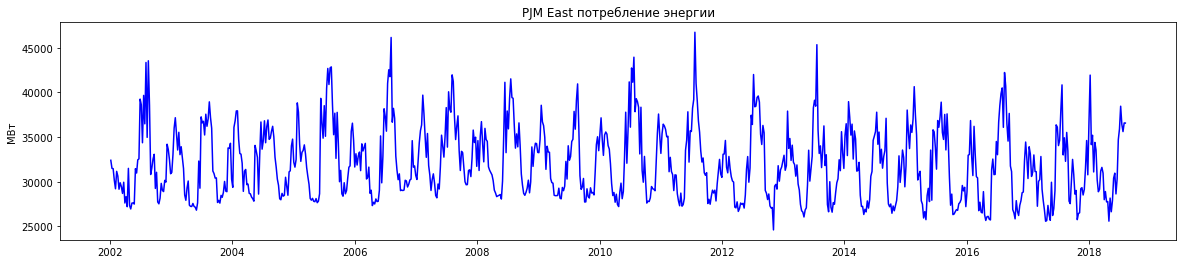

In [19]:
plt.figure(figsize =(20,4))
plt.plot( data_week.index, data_week, 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [20]:
data_week['date'] = data_week.index

In [21]:
data_week['year'] = data_week['date'].dt.year
data_week['month'] = data_week['date'].dt.month
data_week['quarter'] = data_week['date'].dt.quarter

In [23]:
data_week.drop( columns = 'date', inplace = True )

In [114]:
df = data_week.copy() 

In [115]:
df['t1'] = 0
df['t2']=0
df['t3']=0

df.fillna(0)

# добавили сглаживание (4 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)
df['exp_0_03'] = exponential_smoothing(df['PJME_MW'], 0.03)
df['exp_0_05'] = exponential_smoothing(df['PJME_MW'], 0.05)
df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.08)

df.iloc[1:,4]=df.iloc[:-1,0].values
df.iloc[2:,5]=df.iloc[:-2,0].values
df.iloc[3:,6]=df.iloc[:-3,0].values

In [116]:
df.tail()

,PJME_MW,year,month,quarter,t1,t2,t3,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,,
2018-07-08,38459.982143,2018,7,3,35911.839286,34711.648810,30316.940476,31149.351351,30974.370915,31029.513277,31223.895665
2018-07-15,36420.035714,2018,7,3,38459.982143,35911.839286,34711.648810,31202.058195,31137.740859,31299.039399,31639.586869
2018-07-22,35612.095238,2018,7,3,36420.035714,38459.982143,35911.839286,31246.158565,31271.971490,31514.692191,31957.387539
2018-07-29,36581.821429,2018,7,3,35612.095238,36420.035714,38459.982143,31299.515194,31431.266988,31768.048653,32327.342250
2018-08-05,36568.804124,2018,8,3,36581.821429,35612.095238,36420.035714,31352.208083,31585.393102,32008.086426,32666.659200


**2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .**

In [117]:
train, test = split_data_b(df, '2018-07-08')

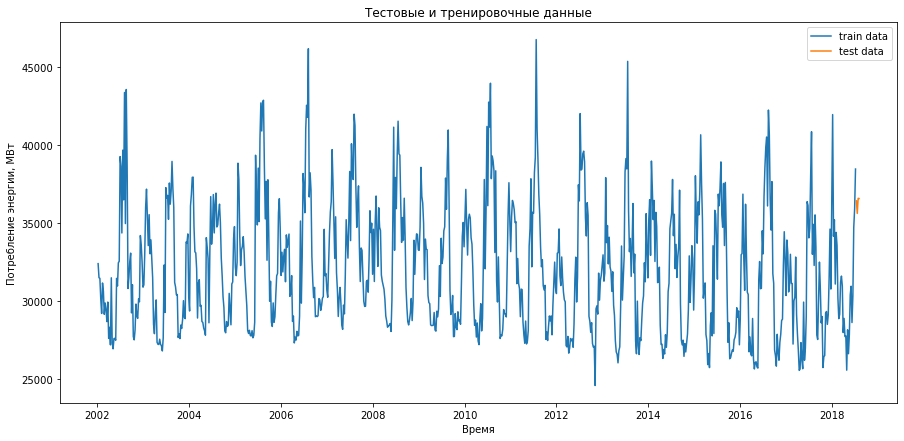

In [118]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [111]:
train.drop('PJME_MW', axis=1, inplace = True )

In [128]:
test.iloc[:-3,:1]

,PJME_MW
Date,
2018-07-15,36420.035714


In [129]:
df.columns[0]

'PJME_MW'

In [132]:
test['PJME_MW'].values[3:]

array([36568.80412371])

In [112]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

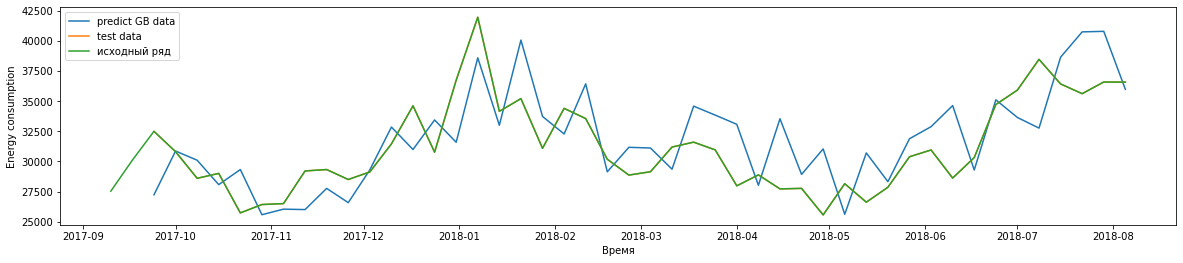

ошибка градиентного бустинга :   8.293517345805327 %


In [47]:
h=1
X_train_b = train.iloc[:-h,:]
y_train_b = train[df.columns[0]].values[h:]
X_test_b = test.iloc[:-h,:]
y_test_b = test[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Energy consumption')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(df.loc['2017-09-10':].index, df.loc['2017-09-10':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [58]:
test[df.columns[0]].values[1:]

array([32490.92857143, 30803.76190476, 28594.95238095, 29003.33333333,
       25727.81547619, 26420.46428571, 26499.36470588, 29206.3452381 ,
       29321.85119048, 28497.52380952, 29121.2202381 , 31447.30357143,
       34607.30357143, 30762.61904762, 36729.10119048, 41951.33928571,
       34149.1547619 , 35201.76190476, 31082.18452381, 34396.17857143,
       33549.75      , 30177.75      , 28863.51785714, 29140.24404762,
       31187.1497006 , 31593.82738095, 30951.83333333, 27970.83928571,
       28880.98809524, 27718.25      , 27760.45833333, 25559.9702381 ,
       28147.99404762, 26616.10714286, 27854.14285714, 30382.39285714,
       30945.60119048, 28615.1547619 , 30316.94047619, 34711.64880952,
       35911.83928571, 38459.98214286, 36420.03571429, 35612.0952381 ,
       36581.82142857, 36568.80412371])

In [57]:
test.iloc[:-1,:]

,PJME_MW,year,month,quarter,t,t1,t2,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,,
2017-09-17,30105.017857,27528.119048,27807.988095,33448.815476,0,0,0,31339.697846,31236.654851,31404.206911,31666.360336
2017-09-24,32490.928571,30105.017857,27528.119048,27807.988095,0,0,0,31351.210153,31274.283063,31458.542994,31732.325795
2017-10-01,30803.761905,32490.928571,30105.017857,27528.119048,0,0,0,31345.735670,31260.167428,31425.803939,31658.040684
2017-10-08,28594.952381,30803.761905,32490.928571,30105.017857,0,0,0,31318.227838,31180.210976,31284.261361,31412.993619
2017-10-15,29003.333333,28594.952381,30803.761905,32490.928571,0,0,0,31295.078892,31114.904647,31170.214960,31220.220797
2017-10-22,25727.815476,29003.333333,28594.952381,30803.761905,0,0,0,31239.406258,30953.291972,30898.094986,30780.828371
2017-10-29,26420.464286,25727.815476,29003.333333,28594.952381,0,0,0,31191.216839,30817.307141,30674.213451,30431.999244
2017-11-05,26499.364706,26420.464286,25727.815476,29003.333333,0,0,0,31144.298317,30687.768868,30465.471014,30117.388481
2017-11-12,29206.345238,26499.364706,26420.464286,25727.815476,0,0,0,31124.918786,30643.326159,30402.514725,30044.505022
